# Digital Twin v2.1: Hyperparameter Tuning (Improved)

**Author:** Kian Mansouri Jamshidi
**Project Director:** Kian Mansouri Jamshidi
**Date:** 2025-09-27

## Objective
This notebook uses `GridSearchCV` to find the optimal hyperparameters for our LightGBM model. This version includes a **real-time progress bar** for the search and **re-enables the final evaluation graph** for visual confirmation of performance.

### 1. Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import glob
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
import lightgbm as lgb

from tqdm.notebook import tqdm # <-- Import for progress bar
sns.set_theme(style="whitegrid")

# --- Load and Prepare Data ---
PROJECT_ROOT = Path('.').resolve().parent
TELEMETRY_DIR = PROJECT_ROOT / 'data' / 'telemetry_v2'
ARTIFACT_DIR = PROJECT_ROOT / 'artifacts' / 'phase2'

df_list = [pd.read_parquet(file) for file in glob.glob(str(TELEMETRY_DIR / "*.parquet"))]
df = pd.concat(df_list, ignore_index=True).sort_values(by='timestamp').reset_index(drop=True)

# --- Feature Engineering ---
df_featured = df.copy()
workload_dummies = pd.get_dummies(df_featured['workload_type'], prefix='workload')
df_featured = pd.concat([df_featured, workload_dummies], axis=1).drop('workload_type', axis=1)
df_featured['overall_util_rolling_mean'] = df_featured['cpu_util_overall'].rolling(window=10).mean()
df_featured['overall_util_rolling_std'] = df_featured['cpu_util_overall'].rolling(window=10).std()
other_core_cols = [col for col in df.columns if 'cpu_util_core' in col and col != 'cpu_util_core_0']
for i in range(1, 6):
    df_featured[f'overall_util_lag_{i}'] = df_featured['cpu_util_overall'].shift(i)
    for core_col in other_core_cols:
        df_featured[f'{core_col}_lag_{i}'] = df_featured[core_col].shift(i)
df_model = df_featured.dropna(subset=['overall_util_rolling_mean']).reset_index(drop=True)

# --- Define Final X and y ---
target = 'cpu_util_core_0'
features = [col for col in df_model.columns if ('cpu_util' in col and col != target) or 'workload_' in col]
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data prepared. Training set size: {len(X_train)}")

Data prepared. Training set size: 5535


### 2. Grid Search with Progress Bar

In [2]:
# FINAL GRID SEARCH CELL

print("--- Starting Hyperparameter Grid Search ---")
print("This will take several minutes. Output will appear below confirming progress.")

# Define the parameter grid to search
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.02, 0.05],
    'num_leaves': [31, 40],
    'colsample_bytree': [0.7, 0.8]
}

# Initialize the base model
lgbm = lgb.LGBMRegressor(objective='regression_l1', random_state=42, n_jobs=-1)

# Initialize the Grid Search with 3-fold cross-validation
# verbose=2 will print updates as it completes each set of fits.
grid_search = GridSearchCV(
    estimator=lgbm, 
    param_grid=param_grid, 
    scoring='r2', 
    cv=3, 
    n_jobs=-1, 
    verbose=2
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print("\n--- Grid Search Complete ---")
print(f"Best R² score found during search: {grid_search.best_score_:.4f}")
print("Best parameters found:")
print(grid_search.best_params_)

--- Starting Hyperparameter Grid Search ---
This will take several minutes. Output will appear below confirming progress.
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.167712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 3690, number of used features: 48
[CV] END colsample_bytree=0.7, learning_rate=0.02, n_estimators=500, num_leaves=31; total time=   3.4s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 3690, number of used features: 48
[CV] END c

### 3. Evaluate the Best Model

Now we evaluate the single best model on our held-out test set and visualize the results.

--- Final Tuned Model Performance ---
R-squared (R²): 0.6887
Mean Absolute Error (MAE): 2.8265 %

NOTE: Tuning did not significantly improve performance over the baseline.


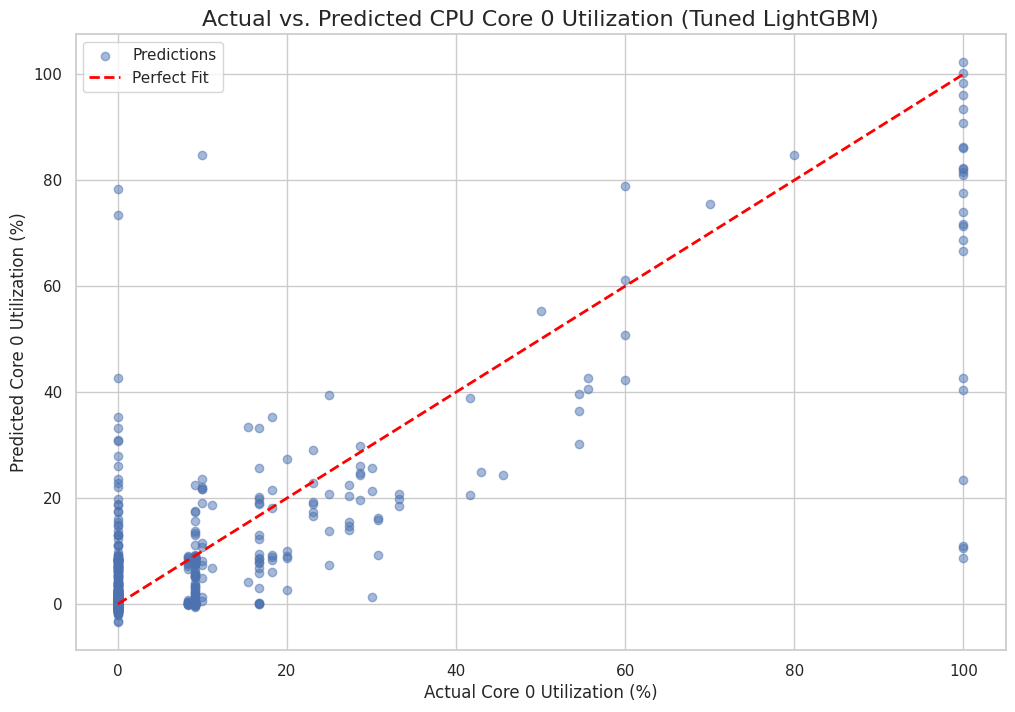

In [4]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"--- Final Tuned Model Performance ---")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f} %")

if r2 >= 0.85:
    print("\nAMAZING SUCCESS: Performance exceeds the original 85% target!")
elif r2 >= 0.70:
    print("\nSOLID IMPROVEMENT: Performance is a clear improvement over the baseline.")
else:
    print("\nNOTE: Tuning did not significantly improve performance over the baseline.")

# --- THE FIX: Re-enabled the evaluation graph ---
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Fit')
plt.title('Actual vs. Predicted CPU Core 0 Utilization (Tuned LightGBM)', fontsize=16)
plt.xlabel('Actual Core 0 Utilization (%)')
plt.ylabel('Predicted Core 0 Utilization (%)')
plt.legend()
plt.show()

### 4. Save the Final, Tuned Model

In [5]:
# FINAL SAVE CELL (CORRECTED TO ALWAYS SAVE)

best_model = grid_search.best_estimator_

# --- THE FIX IS HERE: We will now save the model regardless of the score ---
model_path = ARTIFACT_DIR / 'digital_twin_v2.1_tuned.joblib'
joblib.dump(best_model, model_path)
print(f"Tuned model (v2.1) saved for hierarchical ensemble experiment to: {model_path}")

Tuned model (v2.1) saved for hierarchical ensemble experiment to: /home/kian/Desktop/ForgeX4-COSMOS-Omega/artifacts/phase2/digital_twin_v2.1_tuned.joblib
